Cryptography

### Team
<ol>
    <li> Mark Pearson </li>
    <li> Ronan Geraghty</li>
    <li> Milan Patel </li>
    <li> Will Steynor </li>
</ol>



In [1]:
from NumberFunctions import *
import numpy as np
import random as ran
import matplotlib.pyplot as plt
from time import process_time
import pandas as pd
import numba
import time
import secrets

Stuff extra to include

+ difference between asymmetric and symmetric cryptography

+ Steganography

+ wrighting own pow function with acceleration Done

# Introduction

### Style Guide - PEP 8

Our group will be using the coding style PEP 8 in this project. A PEP stands for 'Python Enhancement Proposal' which is a python document proving information for the Python community. For example, PEP 1 is called 'PEP Purpose and Guidelines'.

We will be using PEP 8 as it will make our code easier to read. Additionally, the project is being developed by different people so having a consistent coding style will make the code feel more seamless and polished.

The guidelines for Pep 8 are at https://www.python.org/dev/peps/pep-0008/

### Big Integers

In this project we want to use numba which will allow us to compile python code. However, one problem we will have with using this is an overflow error with dealing with big integers. A natural example of this would be a hand tally counter, when all the rotors become 9 then the addition of an extra click will make to system go to all zeros. Therefore, the system can count but has to be modulo $10^{\text{number of rotors}}$. An example to do with computers would be,

Assume we have a n-bit machine, we have a max size $2^n -1$. If we do
> $(2^n -1) + (2^n-1) = 2 \cdot 2^n - 2 \geq 2^n -1$

The result will be out of range. The program will either raise an error or carry on the process but only with the last n bits (taking the last n bits is essentially doing $\pmod{2^{n+1}}$). Additionally, if the input to a function is set as 'int64' then the function is limited to working with 64 bit integers. Therefore, for the numba algorithms they can only be used with bits smaller than the bit size of the CPU. Also when there is a square in the algorithm the input has to be a bit number half the bit size of the CPU.



This problem can be solved by creating a type class named something like 'BigInt' for numba. However, the solution created may end up being slower than the normal python implementation. 

By looking at the python source code on github https://github.com/python/cpython/blob/master/Objects/longobject.c, (which is not written in python) we gain an understanding on how python stores and processes integers bigger than the bit size of the CPU.

In Python $3.x$ the types 'long' and 'int' were merged together. Therefore, the integers are non limited in length. These integers are stored in base $2^{30}$, with the number being stored in a int32 array. Below is an example:

> \begin{align*}
& 64563604292343170255\\
=& 1231 \cdot (2^{30})^{0} + 32 \cdot (2^{30})^1 + 56 \cdot (2^{30})^2
\end{align*}

Therefore, this will be stored as $[1231, 32, 56]$
Since the range for each element is $[0,2^{30}-1]$ two bits are left because these are required for some operations. An example of an operation is when adding, as sometimes the addition will overflow the base $2^{30}$, when this happens it carries over to the next element.

Another interesting method is how python multiplies two large integers together, it doesn't use repeated adding which multiplication is defined as but instead it uses an algorithm called 'Karatsuba Algorithm'.



### The Square and Multiply Algorithm

In this project we want to use numba which will allow us to compile python code. This is because in cryptography many functions take a long time to run. However, the numba module does not support the 'pow' function. Therefore, we will make our own 'pow' function that will be based on Square and Multiply Algorithm. This uses the fact

>$$
[a^b \mod{N}]=
\begin{cases}
[(a^{b/2})^2 \mod{N}], &\textrm{when $b$ is even}\\
[a\cdot (a^{(b-1)/2})^2 \mod{N}], &\textrm{when $b$ is odd}
\end{cases}
$$

In [2]:
@numba.jit(numba.uint64(numba.uint64, numba.uint64, numba.uint64), nopython=True)
def my_pow(a, b, N):
    r"""Square and Multiply

    Calculates a^b mod(N), in time polynomial in |a|,|b| and |N|

    Parameters
    ----------
    a : int, up to 63 bit
    b : int, up to 63 bit
        b > 0
    N : int, up to 31 bit

    Returns
    -------
    int
        The solution to a^b mod(N)   
    """
    x = a
    t = 1
    # So solution is tx^b mod(N)
    while b > 0:
        if b % 2 == 1:
            # Odd
            t, b = (t*x) % N, b-1
        x, b = ((x % N)**2) % N, b//2
    return t

In [3]:
# Tests
assert my_pow(12321, 546547, 2349809) == pow(12321, 546547, 2349809)
assert my_pow(4564, 47, 9809) == pow(4564, 47, 9809)
assert my_pow(2**33, 2**33, 21312) == pow(2**33, 2**33, 21312)

n = 63
assert my_pow(2**n, 2**n, 8589934591) == pow(2**n, 2**n, 8589934591)

In [129]:
%timeit my_pow(12321, 546547, 2349809)
%timeit pow(12321, 546547, 2349809)

667 ns ± 11.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
2.54 µs ± 83 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Therefore, the code which was just created is over $5$x faster than the python built in function.

However, this function has its limits as the parameters have to be 64 bit integers and in a calculation if a number becomes larger than 64 bits then an overflow error occurs, meaning the first few bits will be dropped leading to the incorrect result.

# Core 2: RSA Signature Message

## Modular Inverse

Solve, 
> $ax = 1 \pmod{m} $ for  $x \in \{1,2,3,...,m-1\}$


Proof

We have, where $x,y \in \mathbb{Z}$ are calculated by the Euclidean algorithm.
> $ax+by = gcd(a,b)$

We only need to take into account when $gcd(a,b)=1$ as $e$ is chosen so $gcd(e,\phi{N})=1$

Let $m=b$, where $gcd(a,m) = 1$

So we get
> \begin{align*}
ax+my &= 1\\
ax + my &\equiv 1\pmod{m}\\
ax &\equiv 1\pmod{m}
\end{align*}

Therefore, $x$ is a modular inverse of $a$ for $m$

However, by using the Euclidean algorithm sometimes $x$ is not in the set $\{1,2,...,m-1\}$. This is a problem as if $x$ is negative when we use it later for the RSA signature we need to take the modulo of $int^{x}$, to do this we must have $int = int^{x}$

Let us consider the case where $x \notin \{1,2,...,m-1\}$, Let $d \in \mathbb{Z}$
> \begin{align*}
ax &\equiv 1\pmod{m}\\
ax + adm &\equiv 1\pmod{m}\\
a(x + dm) &\equiv 1\pmod{m}
\end{align*}

Set $x\prime = x + dm \iff x\prime = x \pmod{m}$

We know $x\prime \in \{1,2,...,m-1\}$


In [4]:
@numba.jit('int64(int64)', nopython=True)
def totient_fast(n):
    '''return the totient of n,
        number of postive integers < n which are coprime to n.'''
    num = 0
    for i in range(1, n):
        if gcd_fast(i, n) == 1:
            num += 1
    return num


@numba.vectorize('int64(int64)', nopython=True, target='parallel')
def totient_fast_ufunc_par(n):
    return totient_fast(n)


def totient(n):
    '''return the totient of n,
        number of postive integers < n which are coprime to n.'''
    num = 0
    for i in range(1, n):
        if gcd_fast(i, n) == 1:
            num += 1
    return num


def my_hash(message, N):
    '''Turn message to bits
    Then turn into int h'''
    return hash(message) % N


def modular_inverse(a, n):
    '''Solves ax = 1 mod(n) for x in {1,2,3,...,m-1}'''
    gcd, x, y = gcd_ext(a, n)
    if gcd == 1:
        return x % n
    else:
        return "gcd not = 1"


@numba.jit('int64(int64,int64)', nopython=True)
def modular_inverse_fast(a, n):
    # Solves ax = 1 mod(n) for x in {1,2,3,...,m-1}

    gcd, x, y = gcd_ext_fast(a, n)
    if gcd == 1:
        return x % n
    else:
        return -1


def get_primes_composites(n, is_prime_FUN=isprime_basic):
    '''returns a numpy array of primes and composites with largest number being n,
    is_prime_FUN: which function will be used to identify if a number is prime'''
    primes = []
    composites = []

    for num in range(1, n+1):
        if is_prime_FUN(num):
            primes.append(num)
        else:
            composites.append(num)

    return np.array(primes), np.array(composites)


def primality_test(N, t):
    for i in range(0, t):
        a = ran.randrange(0, N-1)
        if a**(N-1) % N != 1:
            return "composite"
    return "prime"

In [5]:
# Tests

assert totient(7) == 6
assert totient(35) == 24
assert totient(5321) == 4992

assert max(totient_fast_ufunc_par(
    np.array([7, 35, 5321])) - np.array([6, 24, 4992])) < 1e-10

assert modular_inverse(15, 7) == 1
assert modular_inverse_fast(15, 7) == 1

a = 3487
n = 9837
b = modular_inverse(a, n)
d = modular_inverse_fast(a, n)
assert (a*b) % n == 1
assert (a*d) % n == 1

# This test gets negative value originally, but inverse needs to be inbetween {1,2,..,m-1}
a = 3231
n = 12334
assert modular_inverse(a, n) == 11895


expected_primes = np.array([2, 3, 5, 7, 11, 13, 17, 19])
expected_composites = np.array([1, 4, 6, 8, 9, 10, 12, 14, 15, 16, 18, 20])

primes, composites = get_primes_composites(20)
assert max(primes - expected_primes) == 0
assert max(composites - expected_composites) == 0

## Generating primes using Miller Rabin

An n bit number is one which requires n bits to be stored, with the most significant bit (the left most bit) being 1. This means the n bit number is in the range $[2^{n-1}, 2^n)$.

we need to generate primes of n bit length, the idea is to pick a n bit number and check if it is prime. However, with large values of primes the traditional method of checking if numbers divide the prime doesn't work very fast, if n is prime it has at best a speed of $O(\sqrt{n})$. 

However, by using a probabilistic approach to find primes. Large primes can be found. The longer the algorithm is run for the higher the probability of getting a prime is. We will be using the probabilistic method called Miller Rabin.

### How Miller Rabin Works

Let $n$ be prime with $n>2$

So we have $n-1$ must be even, this means it can be written as $2^sd$ with $s,d \in \mathbb{N}_+$ and $d$ odd.

Therefore, we have one of these must be true for each $a\in \{2,3,...,n-1\}$

> $a^d \equiv 1 \mod{n}$

or

>$a^{2^rd} \equiv -1 \mod{n}$ for $r \in \{0,1,2,...,s-1\}$

To prove this we will use Fermat's Little Theorem which states for a prime number $n$ and $a\in \mathbb{Z}/n\mathbb{Z}$.
> $a^{n-1} \equiv 1\mod{n} \iff a^{n} \equiv a \mod{n}$

This can be written as
>$a^{n-1} = a^{2^sd}$

Then by taking square roots
>\begin{align*}
\sqrt{a^{2^sd}} &\equiv \sqrt{1} \mod{n}\\
&\text{ }\\
a^{2^{s-1}d} &\equiv +1 \mod{n} \\
\textrm{or}&\\
a^{2^{s-1}d} &\equiv -1 \mod{n}
\end{align*}

If it is $+1$ we square root again, when we get the modulo equal to $-1$ we can no longer take any more square roots so that equation is true. Therefore, we get one of the above equations must be true.

However, we will be using the contrapositive of the above claim,

The contrapositive states,
> $(P \rightarrow Q) \iff (\neg{Q} \rightarrow \neg{P})$

So we get the contrapositive of the above claim is 
> $a^d \not\equiv 1 \mod{n}$

and

>$a^{2^rd} \not\equiv -1 \mod{n}$ for $r \in \{0,1,2,...,s-1\}$

Then $n$ is not a prime,

When $a$ satisfies these equations $a$ is know as a witness for the composition of $n$.

When $a$ does not satisfy these equations and $n$ is composite, $a$ is known as a strong liar. This means $n$ is a strong probable prime to base $a$.

By randomly picking $a\in\{2,3,...,n-1\}$ multiple times it is unlikely for all of the selected $a$ to be strong liars.

This leads to the fact, if $p$ is $prime$, then the Miller Rabin test outputs $prime$. If p is $composite$, the algorithm outputs $composite$ but has a small chance of outputting $prime$.

In [6]:
def random_prime(n_bit, t, trails=500):
    '''Returns a uniform n-bit prime, with probability at most 2^(-t) getting a composite,
    the higher the trails the less chance of failing to generate a prime but takes longer'''
    for i in range(0, trails):
        p = [secrets.choice([0, 1]) for i in range(0, n_bit-2)]
        b = "".join(str(i) for i in p)
        my_int = int("1" + b + "1", 2)  # Want at least n bit and gives odd
        if is_prime_miller_rabin(my_int, t):
            return my_int
    return "Fail"


def is_prime_miller_rabin(N, t=40):
    '''If N is prime, test always outputs True(prime)
    If N is composite outputs False(not prime) except with probability at most 2^(-t)'''

    if N == 2:
        return True  # Prime

    if N == 3:
        return True  # Prime

    if N % 2 == 0:
        return False  # Comp

    if N < 2:
        return False  # Comp

    d, s = calc_d_s(N)
    for j in range(0, t):
        a = ran.randrange(2, N-1)
        if is_composite(N, d, s, a):
            return False  # Comp
    return True  # Prime


def is_composite(N, d, s, a):
    '''Evaulate a^d != +-1 mod(N), and, a^(d*2^r) != -1 mod(N) for r in {1,2,...,s-1},
    However, if output False does not mean prime, it could be a strong liar'''
    remain = pow(a, d, N)
    if (remain != 1) and (remain != N - 1):
        for r in range(1, s):
            remain = pow(remain, 2, N)
            if remain != N-1:
                pass
            else:
                return False
    else:
        return False

    return True


def calc_d_s(N):
    s = 0
    Num = N - 1
    while Num % 2 == 0:
        Num //= 2
        s += 1
    d = Num
    return int(d), int(s)

In [7]:
# Tests
assert calc_d_s(71)[0] == 35
assert calc_d_s(71)[1] == 1
assert calc_d_s(127)[0] == 63
assert calc_d_s(127)[1] == 1
assert calc_d_s(9627824804082068411)[0] == 4813912402041034205
assert calc_d_s(9627824804082068411)[1] == 1
assert calc_d_s(203981900391787397947)[0] == 101990950195893698973
assert calc_d_s(203981900391787397947)[1] == 1


N, d, s = 221, 55, 2
# 137 is a witness for compositeness of 221
a = 137
assert is_composite(N, d, s, a) == True

# 174 will lead to 221 being a prime or 174 is a strong liar for 221
a = 174
assert is_composite(N, d, s, a) == False

N, d, s = 71, 35, 1
a = 19
assert is_composite(N, d, s, a) == False


assert is_prime_miller_rabin(203981900391787397947, 40) == True
assert is_prime_miller_rabin(-1235, 40) == False
assert is_prime_miller_rabin(1, 40) == False
assert is_prime_miller_rabin(3, 40) == True

# Tests
expected_primes = np.array([2, 3, 5, 7, 11, 13, 17, 19])
expected_composites = np.array([1, 4, 6, 8, 9, 10, 12, 14, 15, 16, 18, 20])

primes, composites = get_primes_composites(20, is_prime_miller_rabin)
assert max(primes - expected_primes) == 0
assert max(composites - expected_composites) == 0

In [8]:
def gen_modulas(n_bit):
    '''n_bit is the size of the primes you want, the secuirty level.
    This will output (N,p,q), N = p*q, p,q are n_bit uniform primes'''

    p = ""
    q = ""

    while type(p) == str or type(q) == str:
        p = random_prime(n_bit, 40)
        q = random_prime(n_bit, 40)
    N = p*q
    return N, p, q


def choose_e(phi_n):
    e = 2
    while True:
        if gcd(e, phi_n) == 1:
            return e
        else:
            e += 1


def gen_RSA(n_bit):
    '''n_bit is the size of the primes you want, the secuirty level.
    output, N,e,f, N = p*q, e is relatively prime to phi(N), f solves ef = 1mod(phi(N))'''
    N, p, q = gen_modulas(n_bit)
    phi_n = (p-1)*(q-1)
    e = choose_e(phi_n)
    f = modular_inverse(e, phi_n)
    return N, e, f

In [9]:
assert choose_e(448) == 3

## The RSA-FDH Signature Scheme

This is from the hash and sign paradigm. Where FDH means full domain hash. There are three stages to this scheme: Generation, Sign and Verify
+ Generation
  - We input the n-bit size of the random uniform primes we want
  - This will give us a private key $(N,f)$ and public key $(N,e)$
  - Where $N=pq$ and
  > $ef \equiv 1 \mod{\phi{N}} $
  - A hash function $H$ is generated so all outputs are in $\{1,2,3,...,N-1\}$
  - The hash function $H$ is part of the public key
+ Sign
  - We input the private key $(N,f)$ and a message which will be hashed by $H$ into $h$
  - So we can compute the $s \in \mathbb{Z}$, which is the signature
  > $s \equiv m^d \pmod{N}$  
+ Verify
  - We input the public key $(N,e)$ and a message which will be hashed by $H$ into $h\prime$
  - We input $s$ the signature
  - Output $1$ which means authenticated if and only if
  > $h \equiv s^e \pmod{N}$

This works as
> $s^e \equiv (h^f)^e \equiv h^{ef \mod{\phi{N}}} \equiv h^1 \equiv h\mod{N}$

The reason why this is effective is because calculating $\phi{N}$ is very difficult, but with extra information $pq=N$ where $p,q \in$ Primes it makes $\phi{N}$ easy to calculate, this is know as a trap door. Additionally, the private key can be calculated from knowing the public key and the two primes that make up $N$.

Where $\phi{}$ is the Euler totient function. 

In [10]:
def Generation(n_bit):
    '''input: n_bit, size of primes wanted
    output: private and public key'''
    N, e, f = gen_RSA(n_bit)
    private_key = {"N": N, "f": f}
    public_key = {"N": N, "e": e}
    return private_key, public_key


def Sign(message, private_key):
    h = my_hash(message, private_key["N"])
    s = pow(h, private_key["f"], private_key["N"])
    return s


def Verify(message, s, public_key):
    h_prime = my_hash(message, public_key["N"])
    h = pow(s, public_key["e"], public_key["N"])

    if h_prime == h:
        return 1  # Authenticated
    else:
        return 0  # Intruder

### Note, why is $\phi{(pq)}$ is easy to calculate

For large $N$, we have $\phi{(N)}$ is difficult to calculate. But since $\phi$ is a multiplicative function we have when $a,b$ are relatively prime ($gcd(a,b)=1$). Then,
> $\phi{(ab)} = \phi{(a)}\phi{(b)}$

We also have by the definition of the Euler totient function, for all $p\in primes$
> $\phi{(p)} = p-1$

This means if two primes denoted by $p,q$ can be found such that $N=pq$, then $\phi{(N)}$ can be quickly calculated by
> $\phi{(N)} = \phi{(p)}\phi{(q)} = (p-1)(q-1)$


Below is a graph of the totient function for the first 500 numbers

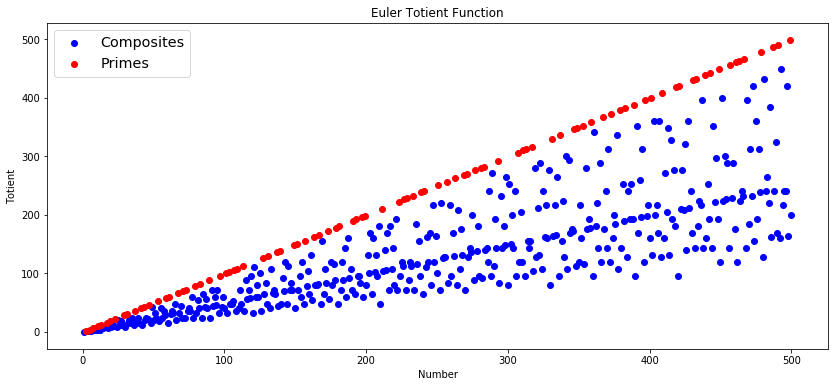

In [11]:
x_prime, x_comp = get_primes_composites(500)

y_prime = np.array([totient(x_prime[i]) for i in range(0, len(x_prime))])
y_comp = np.array([totient(x_comp[i]) for i in range(0, len(x_comp))])

plt.figure(figsize=(14, 6))
plt.scatter(x_comp, y_comp, color="blue", label="Composites")
plt.scatter(x_prime, y_prime, color="red", label="Primes")
plt.title("Euler Totient Function")
plt.ylabel("Totient")
plt.xlabel("Number")
plt.legend(fontsize="x-large")
plt.show()

Below is also an Euler Totient graph but this time it is calculated with compiled code and on multiple threads thus using all CPU's. This means more numbers can be shown. 

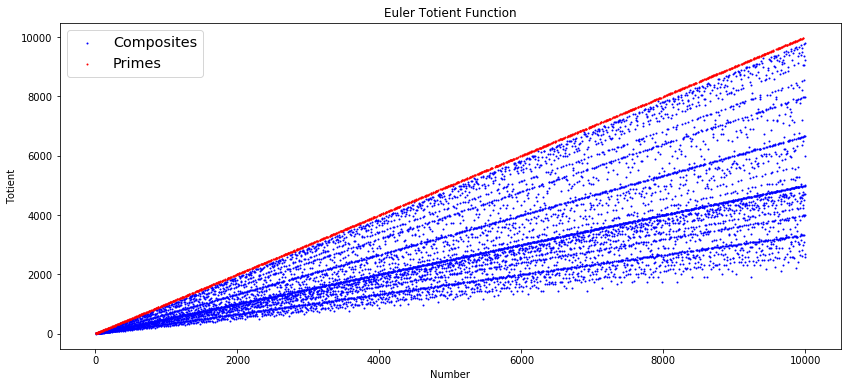

In [12]:
x_prime, x_comp = get_primes_composites(10000, is_prime_FUN=isprime_basic_fast)


y_prime = totient_fast_ufunc_par(x_prime)
y_comp = totient_fast_ufunc_par(x_comp)

plt.figure(figsize=(14, 6))
plt.scatter(x_comp, y_comp, color="blue", label="Composites", s=1)
plt.scatter(x_prime, y_prime, color="red", label="Primes", s=1)
plt.title("Euler Totient Function")
plt.ylabel("Totient")
plt.xlabel("Number")
plt.legend(fontsize="x-large")
plt.show()

### Note, forms of private key

If the private key is of the format $(p,q)$ where $N=pq$ given the public key $(N,e)$, the private key can be written in the format $(N,f)$ where $fe \equiv 1 \mod{\phi(N)}$ by the following code

In [13]:
def convert_to_N_f(prime_private_key, public_key):
    '''inputs private key of form two primes and public key
    outputs the new private key of form(N,f)'''
    p = prime_private_key["p"]
    q = prime_private_key["q"]
    N = public_key["N"]
    e = public_key["e"]

    if p*q != N:
        return "The private key does not work with public key"

    phi_N = (p-1)*(q-1)
    f = modular_inverse(e, phi_N)
    new_private_key = {"N": N, "f": f}
    return new_private_key

In [14]:
# Tests
prime_private_key = {"p": 41, "q": 61}
public_key = {"N": 2501, "e": 7}
private_key = convert_to_N_f(prime_private_key, public_key)
assert private_key == {"N": 2501, "f": 343}

## Examples of RSA Signature

### Example 1, no intruder

Bob wants to know the message he has been sent is from Alice. Therefore, Alice needs to generate private and public keys, sign the message. When Bob receives the message he has to verify the message is from Alice.

In [15]:
message = "Hello Bob my freind"
# Generate keys with 512 bit primes
private_key, public_key = Generation(512)

# Alice needs to sign message
s = Sign(message, private_key)

# s and message are sent to Bob
# Bob should also have access to the public key
# Bob will now verify Alice sent the message
Verification = Verify(message, s, public_key)
Verification

1

As can be seen the verification process passed so Bob knows Alice sent the message.

Sometimes with very small probability the prime generator will produce a composite number. However, this is fine as then the message will fail the verification process and then the signature process happens again.

### Example 2, intruder Dave

Bob wants to know the message he has been sent is from Alice. And that Dave has not captured and changed the message. Same as before  Alice needs to generate private and public keys, sign the message. When Bob receives the message he has to verify the message is from Alice. If the message fails verification Dave has changed the message. 

In [16]:
message = "Hello Bob my freind"
# Generate keys with 512 bit primes
private_key, public_key = Generation(512)

# Alice needs to sign message
s = Sign(message, private_key)

# s and message are sent to Bob
# Bob should also have access to the public key

# Dave intercepts the message and changes it
message = "I declare war on Bob"
# Dave sends new message to Bob

# Bob will now verify Alice sent the message
Verification = Verify(message, s, public_key)
Verification

0

The verification failed this means Bob knows that someone has intercepted and changed the message. 

### Example 3, 6 bit primes with tests and calculations

Let the message be hashed to $h$ where $h=15$, we will use 6 bit primes $p=41$ and $q=61$ so we get $N=2501$, we will use the fact that the Euler's totient function is multiplicative and $\phi{prime} = prime - 1$.
>$\phi{2501} = \phi{41}\phi{61} = 40*60 = 2400$

In [17]:
assert totient(2501) == 2400

We will select $e=7$ as $gcd(7,2400)=1$

calc by hand show working
if test then we get all pass

In [18]:
assert choose_e(2400) == 7

We need to solve for f
>\begin{align*}
ef &\equiv 1 \mod{\phi{N}}\\
7f &\equiv 1 \mod{2400}\\
f &= 343
\end{align*}

In [19]:
assert modular_inverse(7, 2400) == 343

Therefore, we get private key $(N=2501, f=343)$ and public key $(N=2501, e=7)$

In [20]:
private_key = {"N": 2501, "f": 343}
public_key = {"N": 2501, "e": 7}
message = 15

We need to sign the message, the signature $s$
>\begin{align*}
s &\equiv h^f \mod{N}\\
s &\equiv 15^{343} \mod{2501}\\
s &= 1053
\end{align*}

In [21]:
s = Sign(message, private_key)
assert s == 1053

The message and signature are sent off to the person, the person will verify the message by checking if their $h\prime = h$.

Let us consider the case where the message is not changed.

>\begin{align*}
h &\equiv s^e \pmod{N}\\
h &\equiv 1053^{7} \pmod{2501}\\
h &= 15
\end{align*}

So since $h\prime = h$ the message will be verified.

In [22]:
assert Verify(message, s, public_key) == 1

This time the same message is sent but a middle man intercepts the message and changes it. Let the new message be hashed to $h\prime=16$. Therefore, $h\prime \neq h$.


In [23]:
message = 16
assert Verify(message, s, public_key) == 0

The middle man will struggle to forge $s$ as they will struggle to find $f$ as they know $e$ and $N$ but only knowing that information makes solving $ef \equiv 1 \mod{\phi{N}}$ for $f$ difficult for large $N$ as $\phi{N}$ takes a long time to calculate.

## Problems with the Plain RSA signature

The Plain RSA signature is the same as the RSA-FDH signature but without the hash function $H$. This means only integers in $\{1,2,...,N-1\}$ can be sent as the message. With this signature there are a few forms of attacks.

### A no control of message attack,

This attack only requires the public key $(N,e)$, it works as follows. The attacker uniformly picks a signature $s$ where $s\in\{1,2,3,...,N-1\}$. Then calculates the message $h$ where 
>$h \equiv s^e \mod{N}$

Therefore, the message $h$ has a valid signature $s$, this is a forgery as no signatures were signed by the owner of the public key. However, the attacker has no control over the messages $h$ that get forged.

If this attack is repeated multiple times for different values of the signature $s$ then the attacker can pick a forged message which suits their needs.

### Forging a signature on an arbitary message

Say the attacker wants to forge a message $h\in\{1,2,3,...,N-1\}$ with respect to the public key $(N,e)$, then the attacker picks  $h_1,h_2\in\{1,2,3,...,N-1\}$ which is different from $h$ with
> $h \equiv h_1h_2\mod{N}$

The attacker then needs to obtain valid signatures $s_1, s_2$ for $h_1, h_2$. Then we have $s \equiv s_1s_2 \mod{N}$ is a valid signature for $h$. This is because
>$s^e \equiv (s_1s_2)^e \equiv (h_{1}^{f}h_{2}^{f})^e \equiv h_1^{fe}h_2^{fe} \equiv h_1h_2 \equiv h \mod{N}$

where $f$ is part of the private key, but isn't needed for this to work.

This may not seem devastating but it is dangerous to make assumptions about what messages the signer may or may not be willing to sign.

Additionally, multiple valid signatures $\textbf{s} = \{s_1, s_2, ..., s_q\}$ and their corresponding messages $\textbf{h} = \{h_1,h_2,...,h_q\}$ can be captured. By using the same principle as above the attacker can obtain a valid signature on any of the $2^q-q$ other messages by taking products of the subset $\textbf{h}$.

Furthermore, one example of getting signatures and messages is when a client wants to connect to a server. If a client uses a signature scheme to authenticate with the server and this is done by the client signing a random message sent by the server. It is easy for a malicious server to ask for a certain message to be signed.

## Hash Function

Let $m$ be a string message and $h$ be a hashed message such that $H(m) = h$

This means to prevent these attacks the hash function $H$ must have certain properties.
+ $H$ must be hard to invert, this will prevent the "no control of message attack". As for each valid signature that is forged it is difficult to find the string message $m$ which corresponds to the hashed message $h$

+ $H$ must not have multiplicative relations, that means it is hard to find three messages $m,m_1,m_2$ such that $H(m) = H(m_1)H(m_2)$. This should prevent the "forgery of an arbitrary message".

+ It must be hard to find collisions for $H$. Since if $H(m_1)=H(m_2)$, then $m_1$ and $m_2$ have the same signature, this means forgery of a non signed message is trivial.


# Diffie-Hellman Protocol

## Ronan Part

In [24]:
def sgrandprime(n_bit, t):  # Talk about why we use a prime here, its because using a Prime allows for many more potential Secret
    # Keys when modulo a prime, Also SOphie Germain prime avoids complications with certain primes because p-1 is composite, so
    # The multiplicative group has order p-1, which is mad as it makes it easy to crack
    while True:
        # -1 as 2*p + 1 needs to be n_bit prime
        p = random_prime(n_bit-1, t, trails=5000)
        if is_prime_miller_rabin((2*p)+1, t=40):
            return p, (2*p)+1


Publicprimes = sgrandprime(256, 40)

In [25]:
# Range test
test_prime = sgrandprime(10, 40)[1]
assert test_prime < 2**10
assert test_prime >= 2**(10-1)

In [26]:
def safe_primitive_root(Publicprimes):
    q = Publicprimes[1]
    p = Publicprimes[0]
    b = 2
    primitive = False
    while not primitive:
        if b % q == 1 or (b*b) % q == 1 or pow(b, p, q) == 1:
            b += 1
            continue
        else:
            primitive = True
    return b


pr = safe_primitive_root(Publicprimes)
pr

2

In [27]:
def Private_keys(n, n_bit=256):
    keys = []
    for i in range(0, n):
        keys.append(2**(n_bit - 1) +
                    ran.SystemRandom().getrandbits((n_bit - 1)))
    return keys


keys = Private_keys(2)

Alice_private = keys[0]
Bob_private = keys[1]


def Public_Keys(primiroot, Privates, Prime):
    n = len(Privates)
    Publics = []
    for i in range(0, n):
        Publics.append(pow(primiroot, Privates[i], Prime))
    return Publics


Publics = Public_Keys(pr, keys, Publicprimes[1])

Alice_public = Publics[0]
Bob_public = Publics[1]


def Secret_key(publics, privates, generator):
    n = len(publics)
    publicuse = publics
    for m in range(0, n-1):
        Temp = []
        for i in range(0, n):
            Temp.append(pow(publicuse[(i-1) % n], privates[i], generator))
        for j in range(0, n):
            publicuse[j] = Temp[j]
    Final = Temp
    return Final


Secret_key(Publics, keys, Publicprimes[1])

[70928364235190887467867700674289192938231818735623642855975638415927542034675,
 70928364235190887467867700674289192938231818735623642855975638415927542034675]

In [28]:
# Three parties
threekeys = Private_keys(3)
Three_Alice_private = threekeys[0]
Three_Bob_private = threekeys[1]
Three_Charlie_private = threekeys[2]

Three_Public = Public_Keys(pr, threekeys, Publicprimes[1])

Three_Alice_public = Three_Public[0]
Three_Bob_public = Three_Public[1]
Three_Charlie_public = Three_Public[2]

Secret_key(Three_Public, threekeys, Publicprimes[1])

[84022054422555659165492673128749029613459734880624353535740363700500909662556,
 84022054422555659165492673128749029613459734880624353535740363700500909662556,
 84022054422555659165492673128749029613459734880624353535740363700500909662556]

## Solving the discrete logarithm problem

The discrete logarithm problem is finding $a \in \mathbb{N}$ such that it solves
> $M \equiv g^a\mod{p}$

where $M,g,p \in \mathbb{N}$

So far there are no discrete logarithm algorithms that work in polynomial time on a classical computer. However, there are algorithms in quantum computing like Shor's algorithm that are efficient, this algorithm is for breaking down an integer into its prime factors. But it can be modified to solve the discrete logarithm problem.

A time function will be used to time the function. Therefore, different methods can be compared. This time function can be used to time any function. 

In [29]:
def time_func(Func, num_samples, Func_parameters=[[]]):
    """Times the function

    Parameters
    ----------
    Func : function
        Function that is being timed 
    num_samples : int
        Number of times Func will run
    Func_parameters : 2D array
        Each array in 2D array are the parameters of the Function Func, if num_samples
        greater than number of arrays then it will loop over

    Returns
    -------
    tuple
        mean_time,
        std_time


    Examples
    --------
    time_func(decompose, 4, [[3226322291321]])   
    #will time decompose function 4 times with parameter 3226322291321

    time_func(decompose, 3, [[3304575252941], [1954377239027], [2964234252593]])   
    #will time decompose function 3 times with a differenc parameter each time


    """
    times = np.zeros(num_samples)
    loopover = len(Func_parameters)
    for i in range(num_samples):
        temp_start_time = time.time()
        Func(*Func_parameters[i % loopover])
        temp_finish_time = time.time()
        times[i] = (temp_finish_time - temp_start_time)

    return times.mean(), times.std()

We will now create a function which times how long each discrete logarithm algorithm takes with different bit sizes. It outputs a pandas data frame.

In [30]:
def time_discrete_logarithm(Func, start, stop, num_samples=10):
    r"""time_discrete_logarithm

    Times how long a discrete logarithm algorithm takes to run.
    Outputs a pandas data frame with the results.

    Parameters
    ----------
    Func : Func
        The function that is to solve the discrete logarithm
    start : int
        The bit size to start at
    stop : int
        The bit size to stop at, does not include stop size bit
    num_samples : int, optional
        The number of samples to be taken.  Defaults to 10

    Returns
    -------
    pandas data frame
        index: bit size of p and q
        Mean time: Has the mean time
        Std time: Has the std times

    """

    discrete_logarithm_mean_times = []
    discrete_logarithm_std_times = []

    for n_bit in range(start, stop):
        public_keys = [gen_public_key(n_bit) for i in range(num_samples)]

        input_parameters = format_input_parameters(public_keys)
        temp_mean, temp_std = time_func(
            Func, num_samples, input_parameters)

        discrete_logarithm_mean_times.append(temp_mean)
        discrete_logarithm_std_times.append(temp_std)

    #print("discrete_logarithm_brute_better_fast(g, p, A)")

    my_time_data = {"Mean time": discrete_logarithm_mean_times,
                    "Std time": discrete_logarithm_std_times}
    time_data_frame = pd.DataFrame(data=my_time_data)
    time_data_frame.index = range(start, stop)
    time_data_frame.index.name = "bit size of p and a"

    return time_data_frame


def gen_public_key(n_bit):
    """generates public information

    Generates then calculates public information

    Parameters
    ----------
    n_bit : int
        The size of the p prime wanted

    Returns
    -------
    dict
        The public information
        A : solution to g^a mod(p)
        g : primitive root
        p : large n_bit prime

    """
    q, p = sgrandprime(n_bit, 40)
    g = safe_primitive_root([q, p])
    a = Private_keys(1, n_bit)[0]
    A = pow(g, a, p)
    return {"A": A, "g": g, "p": p}


def format_input_parameters(public_keys, my_order=["g", "p", "A"]):
    """Formats parameters for the function


    Parameters
    ----------
    public_keys : array of dict

    my_oreder : array of str
        What order is wanted for the output

    Returns
    -------
    2D array
        The parameters for the funciton

    """

    formated_public_keys = []

    for public_key in public_keys:
        temp_public_key = []
        for key in my_order:
            temp_public_key.append(public_key[key])
        formated_public_keys.append(temp_public_key)

    return formated_public_keys

In [31]:
# Test format_input_parameters
input_public_keys = [{"A": 307, "g": 5, "p": 863},
                     {"g": 5, "A": 844, "p": 983},
                     {"p": 563, "g": 2, "A": 83}]
expected_format = [[5, 863, 307],
                   [5, 983, 844],
                   [2, 563, 83]]
assert format_input_parameters(input_public_keys) == expected_format

As solving the discrete logarithm problem has time complexity of $\mathcal{O}(2^N)$, we will need a way of finding the curve of best fit in order to predict run times of higher bit numbers.

In [32]:
def log_best_fit(x, y):
    """Finds the best fit values for alpha, beta

    y = alpha*e^(x*beta)

    Parameters
    ----------
    y : array of floats

    x : array of floats

    Returns
    -------
        turple of float
        alpha, beta
        The parameters for the funciton

    """
    x = np.array(x)
    y = np.array(y)
    # Need to disregard any y=0
    index_of_0 = np.where(y == 0)
    x = np.delete(x, index_of_0)
    y = np.delete(y, index_of_0)

    ln_y = np.log(y)

    ln_alpha, beta = best_fit(x, ln_y)
    alpha = np.e**ln_alpha

    return alpha, beta


def best_fit(x, y):
    """Finds the best fit values for alpha, beta

     y = beta*x + alpha


    Parameters
    ----------
    y : array of floats

    x : array of floats

    Returns
    -------
        turple of float
        alpha, beta
        The parameters for the funciton

    """
    x = np.array(x)
    y = np.array(y)

    n = len(x)
    S_xx = sum(x**2)-((sum(x))**2/n)
    S_xy = sum(x*y)-(sum(x)*sum(y)/n)

    beta = S_xy/S_xx
    alpha = y.mean() - beta*x.mean()

    return alpha, beta


def get_prediction(df, start=1, stop=5, step=0.5, ab=False):
    """Get prediction of what further times will be

    Uses linear and exponential regression to predict future times,
    By solving
        y = alpha*e^(x*beta)

    Parameters
    ----------
    df : pandas data frame
        Contains the time it takes for a n bit prime to be solved in discrete logarithum problem.
    start : float, optional
        the n_bit position to start the returned line.
    stop: float, optional
        the n_bit position to finish the returned line, does not include end. 
    step: float, optional
        the smaller the number the higher the detail of the line, defaults to 0.5 .
    ab: boolean, optional
        If the alpha and beta want to be returned instead, defaults to false.

    Returns
    -------
        turple of float arrays
        Points of the predicted line

        alpha, beta
        Curve of best fit

    """
    # process df
    n_bit = np.array(df.index)
    times = np.array(df)

    # find curve of best fit
    alpha, beta = log_best_fit(n_bit, times)

    if ab:
        return alpha, beta

    # get points
    x_vals = np.arange(start, stop, step)
    y_vals = alpha*(np.e**(beta*x_vals))

    return x_vals, y_vals


def calc_time(x, alpha, beta, inverse=False):
    """Maths function for Calculating time

    Calculates
        y = alpha*e^(x*beta)

    Parameters
    ----------
    x : float
    alpha: float
    beta: float
    inverse: boolean, optional
        if true solves the inverse of the function, defaults to False.
    """
    if inverse:
        return (np.log(x)-np.log(alpha))/beta
    else:
        return alpha*(np.e**(x*beta))

In [33]:
# Test best_fit()
test_x = [1, 3, 4]
test_y = [5, 9, 11]
test_alpha, test_beta = best_fit(test_x, test_y)
assert abs(test_alpha - 3) < 0.001
assert abs(test_beta - 2) < 0.001

# Test log_best_fit()
test_x = [0, 1, 2, 3, 4, 5]
test_y = [3, 7, 10, 24, 50, 95]
test_alpha, test_beta = log_best_fit(test_x, test_y)
assert abs(test_alpha - 3.0465) < 0.001
assert abs(test_beta - 0.6871) < 0.001

# Test get prediction
test_df = pd.DataFrame(data={'test data': [3, 7, 10, 24, 50, 95]})
expected_y_vals = [23.934, 47.579, 94.584]
actual_x_vals, actual_y_vals = get_prediction(test_df['test data'], 3, 6, 1)

assert max(abs(actual_x_vals - [3, 4, 5])) < 1e-5
assert max(abs(actual_y_vals - expected_y_vals)) < 1e-1


# Test calc_time()
alpha = 3
beta = 2
x = 4
expected_y = 8942.873961
assert abs(calc_time(x, alpha, beta) - expected_y) < 1e-4

y = 1000
expected_x = 2.90457
assert abs(calc_time(y, alpha, beta, inverse=True) - expected_x) < 1e-4

### Using Brute Force

Here we have a basic brute force method. This method works by starting with $a=1$ then evaluating $g^a\mod{p}$ and comparing it to $M$. By incrementing $a$ until a solution is found.

This method only works if there is a solution for $a$ as "discrete_logarithm_brute(2,4,3)" will run forever. Since this is being used to crack the Diffie-Hellman protocol then there has to be a solution, so this problem can be disregarded.

To make the code run faster numba will be used. This will allow the code to be compiled before running, this means the start up time of a function will be longer but since these methods have many loops the time to complete will be reduced.

In [34]:
def discrete_logarithm_brute(a, N, z):
    """Solves the discrete logarithm problem

    Solves z = a^b mod(N) for b, by using a brute force method 

    Parameters
    ----------
    a : int
    N : int
    z : int

    Returns
    -------
    int
        Solves z = a^b mod(N) for b,
    """

    b = 1
    while True:
        if pow(a, b, N) == z:
            return b
        b += 1


@numba.jit('int64(int64,int64,int64)', nopython=True)
def discrete_logarithm_brute_fast(a, N, z):
    """Solves the discrete logarithm problem

    Solves z = a^b mod(N) for b, by using a brute force method 

    Parameters
    ----------
    a : int
    N : int
    z : int

    Returns
    -------
    int
        Solves z = a^b mod(N) for b,
    """

    b = 1
    while True:
        if my_pow(a, b, N) == z:
            return b
        b += 1

In [35]:
# Tests
assert discrete_logarithm_brute(15, 2342, 167) == 37
assert discrete_logarithm_brute(5, 352, 133) == 25
assert discrete_logarithm_brute(3452, 123456, 39104) == 543

assert discrete_logarithm_brute_fast(15, 2342, 167) == 37
assert discrete_logarithm_brute_fast(5, 352, 133) == 25
assert discrete_logarithm_brute_fast(3452, 123456, 39104) == 543

The method below is still a brute force method. It uses information from the previous loop which means it doesn't have to evaluate $g^a\mod{p}$ every time. However, this comes at the price of using extra storage space which increase space complexity.

In [36]:
def discrete_logarithm_brute_better(a, N, z):
    """Solves the discrete logarithm problem

    Solves z = a^b mod(N) for b, by using a brute force method 

    Parameters
    ----------
    a : int
    N : int
    z : int

    Returns
    -------
    int
        Solves z = a^b mod(N) for b,
    """
    b = 1
    a_new = a
    while True:
        if a_new == z:
            return b
        a_new = (a_new*a) % N
        b += 1


@numba.jit('int64(int64,int64,int64)', nopython=True)
def discrete_logarithm_brute_better_fast(a, N, z):
    """Solves the discrete logarithm problem

    Solves z = a^b mod(N) for b, by using a brute force method, uses a complied version

    Parameters
    ----------
    a : int
    N : int
    z : int

    Returns
    -------
    int
        Solves z = a^b mod(N) for b,
    """
    b = 1
    a_new = a
    while True:
        if a_new == z:
            return b
        a_new = (a_new*a) % N
        b += 1

In [37]:
# Tests
assert discrete_logarithm_brute_better(15, 2342, 167) == 37
assert discrete_logarithm_brute_better(5, 352, 133) == 25
assert discrete_logarithm_brute_better(3452, 123456, 39104) == 543

# Tests
assert discrete_logarithm_brute_better_fast(15, 2342, 167) == 37
assert discrete_logarithm_brute_better_fast(5, 352, 133) == 25
assert discrete_logarithm_brute_better_fast(3452, 123456, 39104) == 543

# Only works up to 16-bit
test_dict = gen_public_key(26)
g = test_dict['g']
p = test_dict['p']
A = test_dict['A']
assert discrete_logarithm_brute_better_fast(
    g, p, A) == discrete_logarithm_brute_better(g, p, A)

### Comparing Brute Force Methods

By comparing these functions it is clear to see that the brute better algorithm is faster. Additionally, the algorithms which are compiled are faster. So from using a better brute force method and compiled code we get the solution runs over $100$ times faster.

In [250]:
%timeit discrete_logarithm_brute(3452, 123456, 39104)
%timeit discrete_logarithm_brute_fast(3452, 123456, 39104)
%timeit discrete_logarithm_brute_better(3452, 123456, 39104)
%timeit discrete_logarithm_brute_better_fast(3452, 123456, 39104)

615 µs ± 1.63 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
83.2 µs ± 76.2 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
56.6 µs ± 121 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
5.4 µs ± 11.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [38]:
dl_brute_times = time_discrete_logarithm(
    discrete_logarithm_brute, 8, 18, 20)  # 21
dl_brute_fast_times = time_discrete_logarithm(
    discrete_logarithm_brute_fast, 10, 20, 20)  # 23
dl_brute_better_times = time_discrete_logarithm(
    discrete_logarithm_brute_better, 12, 22, 20)  # 25
dl_brute_better_fast_times = time_discrete_logarithm(
    discrete_logarithm_brute_better_fast, 13, 26, 20)  # 29

In [39]:
MT = 'Mean time'
ST = 'Std time'

df = pd.DataFrame({'0': dl_brute_times[MT], '1': dl_brute_times[ST],
                   '2': dl_brute_fast_times[MT], '3': dl_brute_fast_times[ST],
                   '4': dl_brute_better_times[MT], '5': dl_brute_better_times[ST],
                   '6': dl_brute_better_fast_times[MT], '7': dl_brute_better_fast_times[ST]})

columns = [('Brute', MT), ('Brute', ST),
           ('Compiled Brute', MT), ('Compiled Brute', ST),
           ('Better Brute', MT), ('Better Brute', ST),
           ('Compiled Better Brute', MT), ('Compiled Better Brute', ST)]

df.columns = pd.MultiIndex.from_tuples(columns)
df.index.name = "bit size of p and a"
df

Brute           Compiled Brute           Better Brute  \
                    Mean time  Std time      Mean time  Std time    Mean time   
bit size of p and a                                                             
8                    0.000100  0.000299            NaN       NaN          NaN   
9                    0.000199  0.000399            NaN       NaN          NaN   
10                   0.000449  0.000496       0.000299  0.000457          NaN   
11                   0.000798  0.000810       0.000500  0.000500          NaN   
12                   0.001744  0.001133       0.001248  0.000766     0.000200   
13                   0.003741  0.002221       0.002245  0.001667     0.000449   
14                   0.005813  0.004835       0.004438  0.003084     0.000700   
15                   0.014312  0.009504       0.011320  0.007447     0.001396   
16                   0.032962  0.020479       0.018698  0.017473     0.003391   
17                   0.081325  0.056288       0.051840  0.034442     0.004438   
18                        NaN       NaN       0.114323  0.056358     0.012517   
19                        NaN       NaN       0.197976  0.133532     0.020524   
20                        NaN       NaN            NaN       NaN     0.039792   
21                        NaN       NaN            NaN       NaN     0.117607   
22                        NaN       NaN            NaN       NaN          NaN   
23                        NaN       NaN            NaN       NaN          NaN   
24                        NaN       NaN            NaN       NaN          NaN   
25                        NaN       NaN            NaN       NaN          NaN   

                              Compiled Better Brute            
                     Std time             Mean time  Std time  
bit size of p and a                                            
8                         NaN                   NaN       NaN  
9                         NaN                   NaN       NaN  
10                        NaN                   NaN       NaN  
11                        NaN                   NaN       NaN  
12                   0.000399                   NaN       NaN  
13                   0.000496              0.000000  0.000000  
14                   0.000458              0.000050  0.000216  
15                   0.000970              0.000150  0.000356  
16                   0.001955              0.000199  0.000399  
17                   0.003617              0.000449  0.000588  
18                   0.007247              0.000997  0.000890  
19                   0.014890              0.001945  0.001355  
20                   0.033228              0.004987  0.002677  
21                   0.053770              0.005934  0.004169  
22                        NaN              0.021394  0.012350  
23                        NaN              0.032564  0.025427  
24                        NaN              0.048996  0.038325  
25                        NaN              0.141127  0.081014

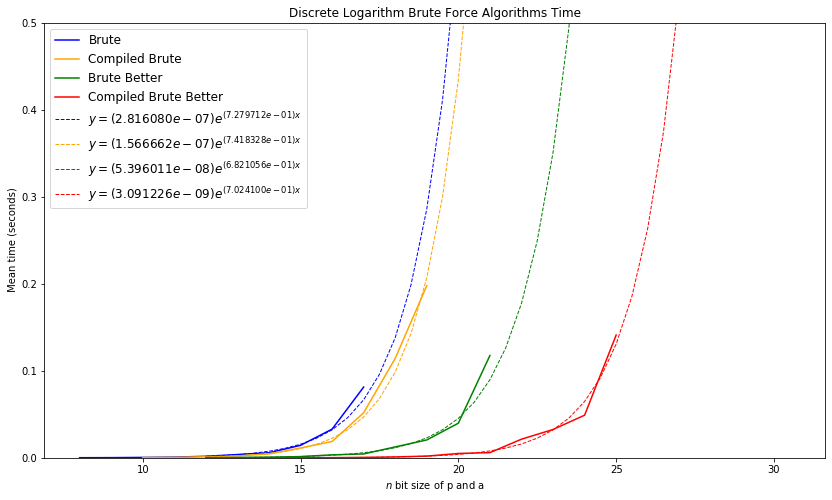

In [40]:
# Make plot
plt.figure(figsize=(14, 8))
# Plot data
plt.plot(dl_brute_times['Mean time'], label='Brute', color='Blue')
plt.plot(dl_brute_fast_times['Mean time'],
         label='Compiled Brute', color='orange')
plt.plot(dl_brute_better_times['Mean time'],
         label='Brute Better', color='green')
plt.plot(dl_brute_better_fast_times['Mean time'],
         label='Compiled Brute Better', color='red')

# The extrapolated curves
plt.plot(*get_prediction(dl_brute_times[MT], 12, 31), linewidth=1,
         linestyle="--", color="blue",
         label=r"$y = (%e) e^{(%e) x}$" % (get_prediction(dl_brute_times[MT], ab=True)))

plt.plot(*get_prediction(dl_brute_fast_times[MT], 12, 31), linewidth=1,
         linestyle="--", color="orange",
         label=r"$y = (%e) e^{(%e) x}$" % (get_prediction(dl_brute_fast_times[MT], ab=True)))

plt.plot(*get_prediction(dl_brute_better_times[MT], 12, 31), linewidth=1,
         linestyle="--", color="green",
         label=r"$y = (%e) e^{(%e) x}$" % (get_prediction(dl_brute_better_times[MT], ab=True)))

plt.plot(*get_prediction(dl_brute_better_fast_times[MT], 12, 31), linewidth=1,
         linestyle="--", color="red",
         label=r"$y = (%e) e^{(%e) x}$" % (get_prediction(dl_brute_better_fast_times[MT],
                                                          ab=True)))

plt.ylim(0, 0.5)
plt.legend(loc="upper left", prop={"size": 12})
plt.xlabel(r"$n$ bit size of p and a")
plt.ylabel(r" Mean time (seconds)")
plt.title(r"Discrete Logarithm Brute Force Algorithms Time")
# plt.yscale('log')

plt.show()

The dashed lines are extrapolated data.

In [41]:
# File save
# Will be frozen so can't run when montoring
start = 6
stop = 70
num_samples = 25


file_name = "BruteForceDiscreteLogData.csv"


for n_bit in range(start, stop):
    public_keys = [gen_public_key(n_bit) for i in range(num_samples)]

    input_parameters = format_input_parameters(public_keys)
    temp_mean, temp_std = time_func(
        discrete_logarithm_brute, num_samples, input_parameters)

    string_to_append = str(n_bit) + ", "
    string_to_append += str(temp_mean) + ", "
    string_to_append += str(temp_std) + ", "
    string_to_append += str(num_samples) + "\n"
    brute_force_file = open(file_name, "a")
    brute_force_file.write(string_to_append)
    brute_force_file.close()

KeyboardInterrupt: 

###  Baby step/Giant step

We are trying to solve for $x$
> $a^x \equiv b \mod{N}$

Let $k\in \mathbb{N}$, set $x = mk + n$ where $m,n \in \mathbb{N}$ such that

>\begin{align*}
&a^{mk+n} \equiv b \mod{N}\\
\iff &a^{n} \equiv ba^{-mk} \mod{N}
\end{align*}

So we are looking for $n,m \in \mathbb{N}$ to satisfy the equation above. We know $0 \leq n < k$, since if $n=k$ then $m$ could be increased and $n$ reduced.
To find this solution we evaluate
>\begin{align*}
&a,a^{2},...,a^{k-1}\mod{N}\\
&ba^{-k}, ba^{-2k}, ..., ba^{-rk}\mod{N}
\end{align*}

until $rk>N$

Stop when $rk>N$ as the order of any element $a$ has to be less than N. Then find the values that are equivalent, this gives a valid value for $m,n$. If none of them are the same then there is no solution.

This algorithm has time complexity and space complexity $\mathcal{O} (\sqrt{n})$ where $n$ is the order of the cyclic group formed by $a^x\mod{N}$

In [41]:
def discrete_logarithm_step(a, N, z):
    """Solves the discrete logarithm problem

    Solves z = a^b mod(N) for b, by using the baby step, giant step method 

    Parameters
    ----------
    a : int
    N : int
    z : int

    Returns
    -------
    int
        Solves z = a^b mod(N) for b,
        if recieved -1 then there is no solution
    """
    k = np.int(np.floor(N**0.5 + 1))
    a_to_k = np.zeros(k-1)
    a_to_k[0] = int(a)
    for i in range(1, k-1):
        a_to_k[i] = pow(int(a*a_to_k[i-1]), 1, N)
    a_inverse = modular_inverse(a, N)
    if a_inverse == 'gcd not = 1':
        return -1
    r = 1
    ba = [pow(a_inverse, k, N)]
    while r*k <= N:
        ba.append(pow(ba[0]*ba[r-1], 1, N))
        r += 1
    ba = np.array(ba)

    ba = z*ba % N

    # Compare elements
    n = 0
    m = 0
    for val in ba:
        if val in a_to_k:
            n = np.where(a_to_k == val)[0][0] + 1
            m = np.where(ba == val)[0][0] + 1
            break
    if (n == 0) and (m == 0):
        return -1
    return m*k+n

In [42]:
# Tests
assert discrete_logarithm_step(3, 59, 19) == 17
assert discrete_logarithm_step(2, 4, 3) == -1

#### Example of Baby Step/Giant Step

We will solve 
> $7^x \equiv 13 \mod{33}$

Therefore, we will let $a=7$, $b=13$, $N=33$ and set $k=Ceiling(\sqrt(N))=6$. As this is the value of $k$ in the code.

First we calculate the sequence

>\begin{align*}
&a,& &a^2,& &a^3,& &a^4,& &a^5,& \mod{N}\\
&\underline{7},& &16,&  &13,&  &25,&  &10,& \mod{33}
\end{align*}

Then calculate the modular inverse,

>\begin{align*}
aa^{-1} &\equiv 1\mod{N}\\
77^{-1} &\equiv 1\mod{33}\\
7^{-1} &\equiv 19\mod{33}
\end{align*}

Now calculate
>\begin{align*}
&ba^{-k},& &ba^{-2k},& &ba^{-3k},& &ba^{-4k},& &ba^{-5k},& &ba^{-6k},& \mod{N}\\
&13\cdot 7^{-6},& &13\cdot 7^{-12},& &13\cdot 7^{-18},& &13\cdot 7^{-24},& &13\cdot 7^{-30},& &13\cdot 7^{-36},& \mod{33}\\
&28,& &\underline{7},&  &10,&  &19,&  &13,& &28&\mod{33}
\end{align*}

We then find the value which is in both lists, in this case there are multiple. We pick the one which gives the smallest value for $x$. In the code it observes 'ba' first and compares it to 'a_to_k' this will guarantee the smallest $x$. 

We have
> $b\cdot a^{-2\cdot6}\equiv 7 \equiv a^1 \mod{33}$

Which leads to 
> $b \equiv a^{1 + 2 \cdot 6} \mod{33}$

So $x=13$

In [43]:
# Now check code folows example
assert discrete_logarithm_step(7, 33, 13) == 13

#### Fast version

In [44]:
@numba.jit(nopython=True)
def isin(element, the_list):
    for selected_element in the_list:
        if element == selected_element:
            return True
    return False


@numba.jit(nopython=True)
def discrete_logarithm_step_fast(a, N, z):
    """Solves the discrete logarithm problem

    Solves z = a^b mod(N) for b, by using the baby step, giant step method, compiled 
    Works up to 16 bit public key

    Parameters
    ----------
    a : int
    N : int
    z : int

    Returns
    -------
    int
        Solves z = a^b mod(N) for b,
        if recieved -1 then there is no solution
    """
    k = np.int(np.floor(N**0.5 + 1))
    a_to_k = np.zeros(k-1)
    a_to_k[0] = int(a)
    for i in range(1, k-1):
        a_to_k[i] = my_pow(int(a*a_to_k[i-1]), 1, N)
    a_inverse = modular_inverse_fast(a, N)
    if a_inverse == -1:  # gcd != 1
        return -1
    r = 1
    ba = np.zeros(N//k + 1)
    ba[0] = my_pow(a_inverse, k, N)
    while r*k <= N:
        ba[r] = (my_pow(ba[0]*ba[r-1], 1, N))
        r += 1

    ba = z*ba % N

    # Compare elements
    n = 0
    m = 0
    for val in ba:
        if isin(val, a_to_k):
            n = np.where(a_to_k == val)[0][0] + 1
            m = np.where(ba == val)[0][0] + 1
            break
    if (n == 0) and (m == 0):
        return -1
    return m*k+n

In [45]:
# Tests

assert isin(2, np.array([1, 4, 6, 2]))
assert not isin(3, np.array([1, 4, 6, 2]))

assert discrete_logarithm_step_fast(7, 33, 13) == 13
assert discrete_logarithm_step_fast(3, 59, 19) == 17
assert discrete_logarithm_step_fast(2, 4, 3) == -1

# Only works up to 16-bit
test_dict = gen_public_key(16)
g = test_dict['g']
p = test_dict['p']
A = test_dict['A']
assert discrete_logarithm_step(
    g, p, A) == discrete_logarithm_step_fast(g, p, A)

### Comparing Baby/Giant Steps Methods

By comparing these functions it is clear to see that the algorithms which are compiled are faster. So from using a compiled version we get the solution runs over $80$ times faster. Because of the overflow error the fast version encounters it sadly can't be used for larger bits.

In [138]:
%timeit discrete_logarithm_step(3452, 123456, 39104)
%timeit discrete_logarithm_step_fast(3452, 123456, 39104)

471 µs ± 8.67 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
6.01 µs ± 73.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [46]:
dl_step_times = time_discrete_logarithm(
    discrete_logarithm_step, 20, 30, 20)  # 35
dl_step_fast_times = time_discrete_logarithm(
    discrete_logarithm_step_fast, 10, 17, 20)  # 17

In [47]:
MT = 'Mean time'
ST = 'Std time'

df = pd.DataFrame({'0': dl_step_times[MT], '1': dl_step_times[ST],
                   '2': dl_step_fast_times[MT], '3': dl_step_fast_times[ST]})

columns = [('Step', MT), ('Step', ST),
           ('Compiled Step', MT), ('Compiled Step', ST)]

df.columns = pd.MultiIndex.from_tuples(columns)
df.index.name = "bit size of p and a"
df

Step           Compiled Step          
                    Mean time  Std time     Mean time  Std time
bit size of p and a                                            
10                        NaN       NaN       0.00000  0.000000
11                        NaN       NaN       0.00000  0.000000
12                        NaN       NaN       0.00000  0.000000
13                        NaN       NaN       0.00000  0.000000
14                        NaN       NaN       0.00000  0.000000
15                        NaN       NaN       0.00000  0.000000
16                        NaN       NaN       0.00005  0.000218
20                   0.003640  0.001105           NaN       NaN
21                   0.006585  0.002316           NaN       NaN
22                   0.008178  0.002742           NaN       NaN
23                   0.011796  0.003973           NaN       NaN
24                   0.018886  0.006092           NaN       NaN
25                   0.028623  0.009241           NaN       NaN
26                   0.045580  0.012693           NaN       NaN
27                   0.059145  0.022122           NaN       NaN
28                   0.102238  0.029111           NaN       NaN
29                   0.157479  0.063423           NaN       NaN

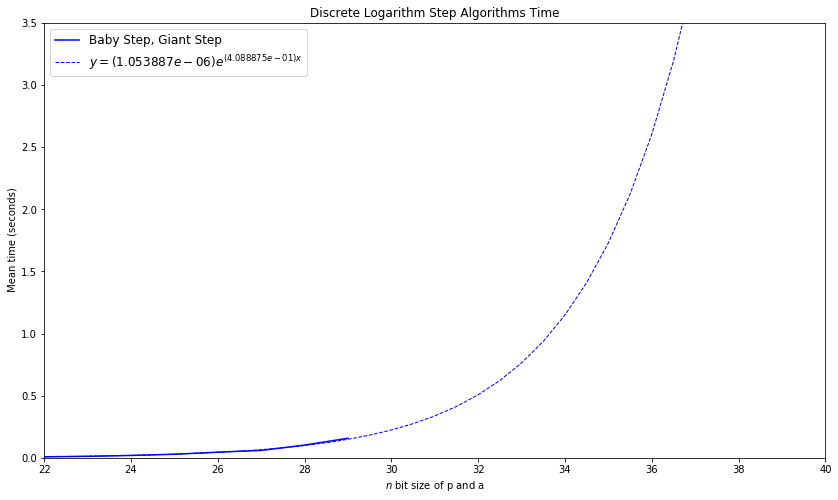

In [48]:
# Make plot
plt.figure(figsize=(14, 8))
# Plot data
plt.plot(dl_step_times['Mean time'],
         label='Baby Step, Giant Step', color='Blue')
# plt.plot(dl_step_fast_times['Mean time'],
# label='Compiled Step', color='orange')


# The extrapolated curves
plt.plot(*get_prediction(dl_step_times[MT], 12, 41), linewidth=1,
         linestyle="--", color="blue",
         label=r"$y = (%e) e^{(%e) x}$" % (get_prediction(dl_step_times[MT], ab=True)))

# plt.plot(*get_prediction(dl_step_fast_times[MT], 12, 41), linewidth=1,
# linestyle="--", color="orange",
# label=r"$y = (%e) e^{(%e) x}$" % (get_prediction(dl_step_fast_times[MT], ab=True)))


plt.ylim(0, 3.5)
plt.xlim(22, 40)
plt.legend(loc="upper left", prop={"size": 12})
plt.xlabel(r"$n$ bit size of p and a")
plt.ylabel(r" Mean time (seconds)")
plt.title(r"Discrete Logarithm Step Algorithms Time")
# plt.yscale('log')

plt.show()

### Comparing Discrete Logarithm Methods

In [222]:
%timeit discrete_logarithm_brute(3452, 123456, 39104)
%timeit discrete_logarithm_brute_fast(3452, 123456, 39104)
%timeit discrete_logarithm_brute_better(3452, 123456, 39104)
%timeit discrete_logarithm_brute_better_fast(3452, 123456, 39104)
%timeit discrete_logarithm_step(3452, 123456, 39104)
%timeit discrete_logarithm_step_fast(3452, 123456, 39104)

681 µs ± 79.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
83.6 µs ± 1.23 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
55.6 µs ± 259 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
5.46 µs ± 283 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
465 µs ± 7.65 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
5.99 µs ± 54 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [49]:
MT = 'Mean time'
ST = 'Std time'


df_all_times = pd.DataFrame({'0': dl_brute_times[MT], '1': dl_brute_times[ST],
                             '2': dl_brute_fast_times[MT], '3': dl_brute_fast_times[ST],
                             '4': dl_brute_better_times[MT], '5': dl_brute_better_times[ST],
                             '6': dl_brute_better_fast_times[MT], '7': dl_brute_better_fast_times[ST],
                             '8': dl_step_times[MT], '9': dl_step_times[ST],
                             '10': dl_step_fast_times[MT], '11': dl_step_fast_times[ST]})

columns = [('Brute', MT), ('Brute', ST),
           ('Compiled Brute', MT), ('Compiled Brute', ST),
           ('Better Brute', MT), ('Better Brute', ST),
           ('Compiled Better Brute', MT), ('Compiled Better Brute', ST),
           ('Step', MT), ('Step', ST),
           ('Compiled Step', MT), ('Compiled Step', ST)]

df_all_times.columns = pd.MultiIndex.from_tuples(columns)
df_all_times.index.name = "bit size of p and a"
df_all_times

Brute           Compiled Brute           Better Brute  \
                    Mean time  Std time      Mean time  Std time    Mean time   
bit size of p and a                                                             
8                    0.000100  0.000299            NaN       NaN          NaN   
9                    0.000199  0.000399            NaN       NaN          NaN   
10                   0.000449  0.000496       0.000299  0.000457          NaN   
11                   0.000798  0.000810       0.000500  0.000500          NaN   
12                   0.001744  0.001133       0.001248  0.000766     0.000200   
13                   0.003741  0.002221       0.002245  0.001667     0.000449   
14                   0.005813  0.004835       0.004438  0.003084     0.000700   
15                   0.014312  0.009504       0.011320  0.007447     0.001396   
16                   0.032962  0.020479       0.018698  0.017473     0.003391   
17                   0.081325  0.056288       0.051840  0.034442     0.004438   
18                        NaN       NaN       0.114323  0.056358     0.012517   
19                        NaN       NaN       0.197976  0.133532     0.020524   
20                        NaN       NaN            NaN       NaN     0.039792   
21                        NaN       NaN            NaN       NaN     0.117607   
22                        NaN       NaN            NaN       NaN          NaN   
23                        NaN       NaN            NaN       NaN          NaN   
24                        NaN       NaN            NaN       NaN          NaN   
25                        NaN       NaN            NaN       NaN          NaN   
26                        NaN       NaN            NaN       NaN          NaN   
27                        NaN       NaN            NaN       NaN          NaN   
28                        NaN       NaN            NaN       NaN          NaN   
29                        NaN       NaN            NaN       NaN          NaN   

                              Compiled Better Brute                Step  \
                     Std time             Mean time  Std time Mean time   
bit size of p and a                                                       
8                         NaN                   NaN       NaN       NaN   
9                         NaN                   NaN       NaN       NaN   
10                        NaN                   NaN       NaN       NaN   
11                        NaN                   NaN       NaN       NaN   
12                   0.000399                   NaN       NaN       NaN   
13                   0.000496              0.000000  0.000000       NaN   
14                   0.000458              0.000050  0.000216       NaN   
15                   0.000970              0.000150  0.000356       NaN   
16                   0.001955              0.000199  0.000399       NaN   
17                   0.003617              0.000449  0.000588       NaN   
18                   0.007247              0.000997  0.000890       NaN   
19                   0.014890              0.001945  0.001355       NaN   
20                   0.033228              0.004987  0.002677  0.003640   
21                   0.053770              0.005934  0.004169  0.006585   
22                        NaN              0.021394  0.012350  0.008178   
23                        NaN              0.032564  0.025427  0.011796   
24                        NaN              0.048996  0.038325  0.018886   
25                        NaN              0.141127  0.081014  0.028623   
26                        NaN                   NaN       NaN  0.045580   
27                        NaN                   NaN       NaN  0.059145   
28                        NaN                   NaN       NaN  0.102238   
29                        NaN                   NaN       NaN  0.157479   

                              Compiled Step            
                     Std time     Mean time  Std time  
bit size o

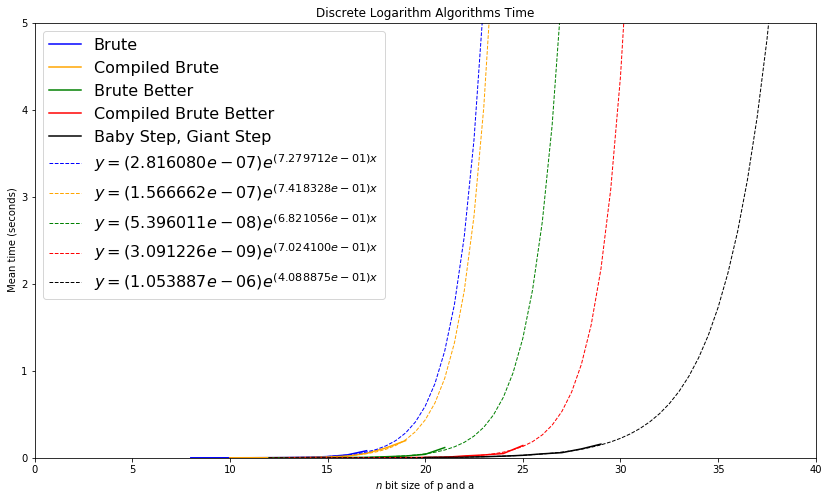

In [50]:
# Make plot
plt.figure(figsize=(14, 8))
# Plot data


# The extrapolated curves


# Plot data
# Brute
plt.plot(dl_brute_times['Mean time'], label='Brute', color='Blue')
plt.plot(dl_brute_fast_times['Mean time'],
         label='Compiled Brute', color='orange')
plt.plot(dl_brute_better_times['Mean time'],
         label='Brute Better', color='green')
plt.plot(dl_brute_better_fast_times['Mean time'],
         label='Compiled Brute Better', color='red')

# Baby/Giant Steps
plt.plot(dl_step_times['Mean time'],
         label='Baby Step, Giant Step', color='black')

# The extrapolated curves
# Brute
plt.plot(*get_prediction(dl_brute_times[MT], 12, 31), linewidth=1,
         linestyle="--", color="blue",
         label=r"$y = (%e) e^{(%e) x}$" % (get_prediction(dl_brute_times[MT], ab=True)))

plt.plot(*get_prediction(dl_brute_fast_times[MT], 12, 31), linewidth=1,
         linestyle="--", color="orange",
         label=r"$y = (%e) e^{(%e) x}$" % (get_prediction(dl_brute_fast_times[MT], ab=True)))

plt.plot(*get_prediction(dl_brute_better_times[MT], 12, 31), linewidth=1,
         linestyle="--", color="green",
         label=r"$y = (%e) e^{(%e) x}$" % (get_prediction(dl_brute_better_times[MT], ab=True)))

plt.plot(*get_prediction(dl_brute_better_fast_times[MT], 12, 31), linewidth=1,
         linestyle="--", color="red",
         label=r"$y = (%e) e^{(%e) x}$" % (get_prediction(dl_brute_better_fast_times[MT],
                                                          ab=True)))

# Baby/Giant Steps
plt.plot(*get_prediction(dl_step_times[MT], 12, 41), linewidth=1,
         linestyle="--", color="black",
         label=r"$y = (%e) e^{(%e) x}$" % (get_prediction(dl_step_times[MT], ab=True)))


plt.ylim(0, 5)
plt.xlim(0, 40)
plt.legend(loc="upper left", prop={"size": 16})
plt.xlabel(r"$n$ bit size of p and a")
plt.ylabel(r" Mean time (seconds)")
plt.title(r"Discrete Logarithm Algorithms Time")
# plt.yscale('log')

# Save the graph as an image
plt.savefig('Discrete Logarithm Algorithms Time Graph')


plt.show()

As discussed earlier in the project we concluded from the NIST (National Institute of Standards and Technology) that for any security method it should take over $2$ years to crack. In this case to crack the Diffie-Hellman protocol (solving the discrete logarithm problem) should take over $2$ years, when the function takes longer than two years to solve this is the point at which the function becomes infeasible. As we don't have time to test what bit size takes over 2 years we will have to use the data gathered and extrapolate. Due to the nature of extrapolation these will be approximations.

Below is a table of the bit size of $p$ and $a$ required to exceed the time needed to solve the discrete logarithm problem using the given method.

In [51]:
h = 60*60  # seconds in hour
d = 24*h  # seconds in day
w = 7*d  # seconds in week
m = 30.42 * d  # seconds in month
y = 365.25 * d  # seconds in year
MT = 'Mean time'


time_seg = [3, 5*h, 12*h, d, w, 2*w, m, 3*m, 6*m, y, 2*y]

time_name = ['1 hour', '5 hours', '12 hours', '1 day', '1 week',
             '2 weeks', '1 month', '3 months', '6 months', '1 year', '2 years']


infeasible_brute_bit = [calc_time(time_val, *get_prediction(dl_brute_times[MT], ab=True),
                                  inverse=True) for time_val in time_seg]

infeasible_brute_fast_bit = [calc_time(time_val, *get_prediction(dl_brute_fast_times[MT], ab=True),
                                       inverse=True) for time_val in time_seg]

infeasible_brute_better_bit = [calc_time(time_val, *get_prediction(dl_brute_better_times[MT], ab=True),
                                         inverse=True) for time_val in time_seg]

infeasible_brute_better_fast_bit = [calc_time(time_val, *get_prediction(dl_brute_better_fast_times[MT], ab=True),
                                              inverse=True) for time_val in time_seg]


infeasible_step_bit = [calc_time(time_val, *get_prediction(dl_step_times[MT], ab=True),
                                 inverse=True) for time_val in time_seg]


df_infeasible = pd.DataFrame(
    {'Time': time_name, 'Brute': infeasible_brute_bit, 'Compiled Brute': infeasible_brute_fast_bit,
     'Brute Better': infeasible_brute_better_bit, 'Compiled Brute Better': infeasible_brute_better_fast_bit,
     'Step': infeasible_step_bit})

df_infeasible

,Time,Brute,Compiled Brute,Brute Better,Compiled Brute Better,Step
0,1 hour,22.228026,22.603154,26.144973,29.460445,36.346516
1,5 hours,34.178381,34.330211,38.898885,41.845683,57.622574
2,12 hours,35.380996,35.510354,40.182365,43.092061,59.763673
3,1 day,36.333159,36.444725,41.198552,44.078874,61.458876
4,1 week,39.006218,39.067837,44.051351,46.849208,66.217911
5,2 weeks,39.958381,40.002208,45.067538,47.836021,67.913114
6,1 month,41.024416,41.048324,46.205255,48.940850,69.811051
7,3 months,42.533559,42.529267,47.815874,50.504911,72.497884
8,6 months,43.485722,43.463638,48.832062,51.491724,74.193086
9,1 year,44.438675,44.398785,49.849092,52.479356,75.889695


Obviously you can't have a n-bit number where $n$ isn't an integer, so taking the ceiling (rounding up) will give the bit size of $p$ and $a$ to solve the discrete logarithm problem in over the time for the given function.

In [52]:
# Saves data fram as CSV file
df_all_times.to_csv('Discrete Logarithm Algorithms Time Table.csv')
df_infeasible.to_csv(
    'Discrete Logarithm Infeasible Bit Times.csv', index=False)

It is very clear to see that the Baby/Giant step algorithm is superior to all of the brute force methods. Therefore, even if an algorithm is written in machine code for the CPU it is quicker to use a more time efficient algorithm it is also a lot easier to code. However, the space complexity (the amount of space used up) for the Baby/Giant step algorithm is inferior to all the brute algorithms, this reason is negligible as the desktops have lots of storage space, first using CPU cache then RAM and if that overflows virtual memory.

# Referencing

KATZ, J.K. LINDELL, Y.L. $\textbf{Introduction To Modern Cryptography}$. 2nd edition. Taylor and Francis group. Dec. 2014

http://numba.pydata.org/numba-doc/latest/user/index.html 24/05/2020

https://github.com/python/cpython 24/05/2020

https://en.wikipedia.org/wiki/Baby-step_giant-step 24/05/2020
